In [11]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored , concordance_index_ipcw
from sklearn.impute import SimpleImputer
from sksurv.util import Surv

In [12]:
#clinical data
df = pd.read_csv(".\X_train\clinical_train.csv")
df.head()

gene_df= pd.read_csv('.\X_train\molecular_train.csv')
#gene_df.head()

In [13]:
rows = df.shape[0]
print(rows)
print(f"{df[df.isna().any(axis=1)].shape[0]} rows ie {df[df.isna().any(axis=1)].shape[0]*100/rows: .2f}% of the whole dataset is Na")
print(f"{df[df['BM_BLAST'].isna()].shape[0]} rows ie {df[df['BM_BLAST'].isna()].shape[0]*100/rows : .2f}% of BM_BLAST is Na")
print(f"{df[df['WBC'].isna()].shape[0]} rows ie {df[df['WBC'].isna()].shape[0]*100/rows : .2f}% of WBC is Na")
print(f"{df[df['ANC'].isna()].shape[0]} rows ie {df[df['ANC'].isna()].shape[0]*100/rows: .2f}% of ANC is Na")
print(f"{df[df['MONOCYTES'].isna()].shape[0]} rows ie {df[df['MONOCYTES'].isna()].shape[0]*100/rows: .2f}% of MONOCYTES is Na")
print(f"{df[df['HB'].isna()].shape[0]} rows ie {df[df['HB'].isna()].shape[0]*100/rows: .2f}% of HB is Na")
print(f"{df[df['PLT'].isna()].shape[0]} rows ie {df[df['PLT'].isna()].shape[0]*100/rows: .2f}% of PLT is Na")



3323
776 rows ie  23.35% of the whole dataset is Na
109 rows ie  3.28% of BM_BLAST is Na
272 rows ie  8.19% of WBC is Na
193 rows ie  5.81% of ANC is Na
601 rows ie  18.09% of MONOCYTES is Na
110 rows ie  3.31% of HB is Na
124 rows ie  3.73% of PLT is Na


In [14]:
df[df['MONOCYTES'].isna()]
df['MONOCYTES']

0       0.70
1       0.10
2       0.10
3       0.10
4       0.90
        ... 
3318    0.53
3319    0.22
3320    0.29
3321    0.11
3322    0.23
Name: MONOCYTES, Length: 3323, dtype: float64

In [15]:
df.describe()

,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT
count,3214.000000,3051.000000,3130.000000,2722.000000,3213.000000,3199.000000
mean,5.982545,6.535164,3.264735,0.955868,9.893549,167.048900
std,7.615439,10.247219,5.237043,2.666478,2.041158,149.477031
min,0.000000,0.200000,0.000000,0.000000,4.000000,2.000000
25%,1.000000,2.700000,1.000000,0.150000,8.500000,65.500000
50%,3.000000,4.100000,2.000000,0.370000,9.700000,123.000000
75%,8.000000,6.655000,3.690000,0.783000,11.200000,229.500000
max,91.000000,154.400000,109.620000,44.200000,16.600000,1451.000000


array([[<Axes: title={'center': 'BM_BLAST'}>,
        <Axes: title={'center': 'WBC'}>],
       [<Axes: title={'center': 'ANC'}>,
        <Axes: title={'center': 'MONOCYTES'}>],
       [<Axes: title={'center': 'HB'}>, <Axes: title={'center': 'PLT'}>]],
      dtype=object)

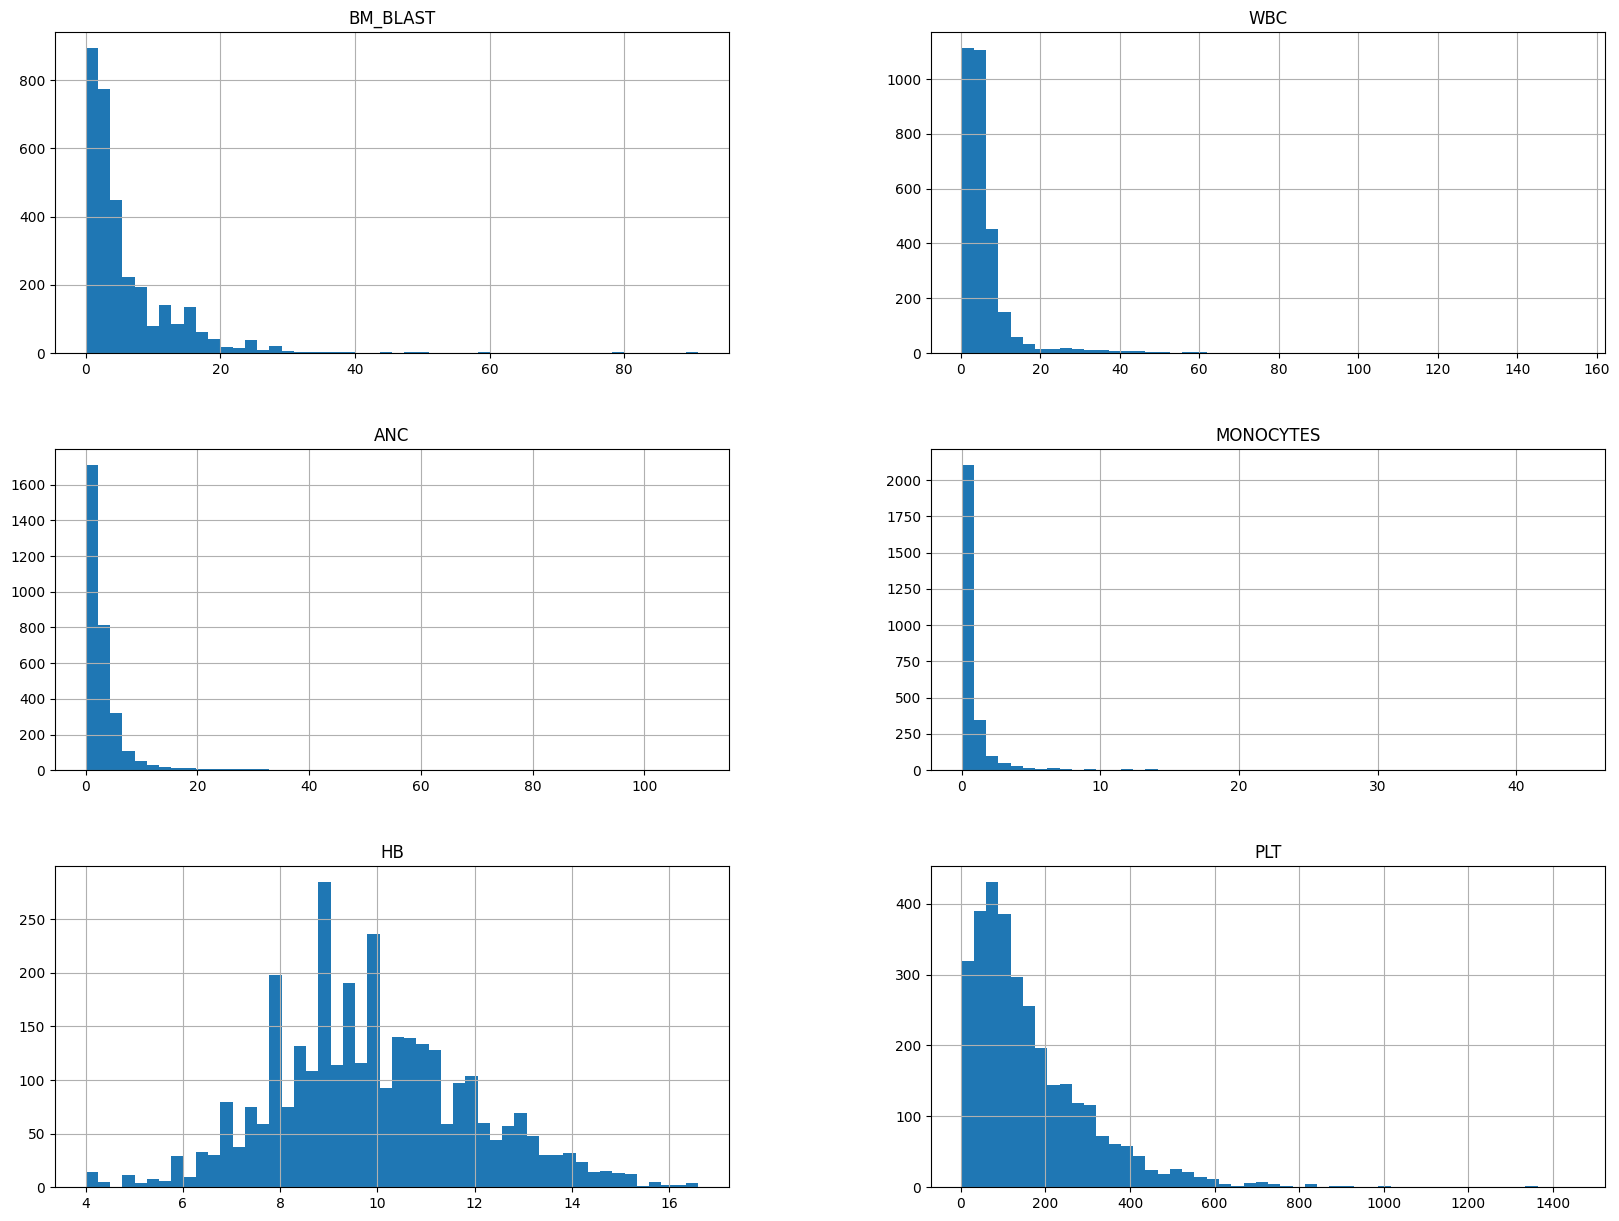

In [16]:
df.hist(bins=50, figsize=(20,15))

In [17]:
correlation = df["HB"].corr(df["BM_BLAST"],method="spearman")
print(f"{correlation}")

-0.050296212361568386


In [18]:
correlation = df[["BM_BLAST","WBC","ANC","MONOCYTES","HB","PLT"]].corr()
type(correlation)

pandas.core.frame.DataFrame

In [19]:
correlation

,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT
BM_BLAST,1.000000,0.100346,-0.008412,0.140248,-0.054530,-0.218223
WBC,0.100346,1.000000,0.847096,0.748100,0.013184,0.020631
ANC,-0.008412,0.847096,1.000000,0.592817,0.012768,0.074716
MONOCYTES,0.140248,0.748100,0.592817,1.000000,0.041912,-0.019550
HB,-0.054530,0.013184,0.012768,0.041912,1.000000,-0.059378
PLT,-0.218223,0.020631,0.074716,-0.019550,-0.059378,1.000000


In [20]:
# no significant correlation therefore impute with median (?)
target_df = pd.read_csv("./target_train.csv")

In [42]:
df[df["CYTOGENETICS"].isna()].shape()

TypeError: 'tuple' object is not callable

In [21]:
# Drop rows where 'OS_YEARS' is NaN if conversion caused any issues
target_df.dropna(subset=['OS_YEARS', 'OS_STATUS'], inplace=True)

# Check the data types to ensure 'OS_STATUS' is boolean and 'OS_YEARS' is numeric
print(target_df[['OS_STATUS', 'OS_YEARS']].dtypes)

# Contarget_dfvert 'OS_YEARS' to numeric if it isn’t already
target_df['OS_YEARS'] = pd.to_numeric(target_df['OS_YEARS'], errors='coerce')

# Ensure 'OS_STATUS' is boolean
target_df['OS_STATUS'] = target_df['OS_STATUS'].astype(bool)

# Select features
features = ["BM_BLAST","WBC","ANC","MONOCYTES","HB","PLT"]
target = ['OS_YEARS', 'OS_STATUS']

# Create the survival data format
X = df.loc[df['ID'].isin(target_df['ID']), features]
y = Surv.from_dataframe('OS_STATUS', 'OS_YEARS', target_df)

OS_STATUS    float64
OS_YEARS     float64
dtype: object


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [23]:
imputer = SimpleImputer(strategy="median")
X_train[['BM_BLAST', 'HB', 'PLT','ANC','MONOCYTES','HB']] = imputer.fit_transform(X_train[['BM_BLAST', 'HB', 'PLT','ANC','MONOCYTES','HB']])
X_test[['BM_BLAST', 'HB', 'PLT','ANC','MONOCYTES','HB']] = imputer.transform(X_test[['BM_BLAST', 'HB', 'PLT','ANC','MONOCYTES','HB']])

In [43]:
#def classify_cytogenetics(cytogenetics):
df[df['CYTOGENETICS'].isna()].shape[0]

387

In [51]:

def classify_cytogenetics(cytogenetics):
    if pd.isna(cytogenetics):
        return 'unknown'
    
    if cytogenetics == 'complex':
        return 'high'

    slash = cytogenetics.count('/')
    commas = cytogenetics.count(',')
    commas = commas-slash-1
    if(commas>=0 and commas<=2):
        return 'low'
    if(commas>2 and commas<=4):
        return 'intermediate'
    if(commas>4):
        return 'high'

In [52]:
df['CYTOGENETICS_RISK'] = df['CYTOGENETICS'].apply(classify_cytogenetics)

In [57]:
df.head()
df['CYTOGENETICS_RISK'].value_counts()

CYTOGENETICS_RISK
low             2527
unknown          387
high             245
intermediate     133
Name: count, dtype: int64

In [24]:
# Import necessary libraries
import lightgbm as lgb
from sksurv.metrics import concordance_index_censored
from sksurv.util import Surv

# Define LightGBM parameters
lgbm_params = {
    'max_depth': 3,
    'learning_rate': 0.05,
    'verbose': -1
}

# Prepare the data for LightGBM
# Scale the target (OS_YEARS) to reduce skew, apply weights based on event status
X_train_lgb = X_train  # Features for training
y_train_transformed = y_train['OS_YEARS']

# Create LightGBM dataset
train_dataset = lgb.Dataset(X_train_lgb, label=y_train_transformed)

# Train the LightGBM model
model = lgb.train(params=lgbm_params, train_set=train_dataset)

# Make predictions on the training and testing sets
pred_train = -model.predict(X_train)
pred_test = -model.predict(X_test)

# Evaluate the model using Concordance Index IPCW
train_ci_ipcw = concordance_index_ipcw(y_train, y_train, pred_train, tau=7)[0]
test_ci_ipcw = concordance_index_ipcw(y_train, y_test, pred_test, tau=7)[0]
print(f"LightGBM Survival Model Concordance Index IPCW on train: {train_ci_ipcw:.2f}")
print(f"LightGBM Survival Model Concordance Index IPCW on test: {test_ci_ipcw:.2f}")

LightGBM Survival Model Concordance Index IPCW on train: 0.70
LightGBM Survival Model Concordance Index IPCW on test: 0.66


In [25]:
y_train

array([(False, 1.91780822), ( True, 1.28219178), ( True, 1.49041096), ...,
       (False, 8.63561644), (False, 0.47671233), (False, 1.29041096)],
      shape=(2221,), dtype=[('OS_STATUS', '?'), ('OS_YEARS', '<f8')])

In [26]:
df.head()

,ID,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,CYTOGENETICS
0,P132697,MSK,14.0,2.8,0.2,0.7,7.6,119.0,"46,xy,del(20)(q12)[2]/46,xy[18]"
1,P132698,MSK,1.0,7.4,2.4,0.1,11.6,42.0,"46,xx"
2,P116889,MSK,15.0,3.7,2.1,0.1,14.2,81.0,"46,xy,t(3;3)(q25;q27)[8]/46,xy[12]"
3,P132699,MSK,1.0,3.9,1.9,0.1,8.9,77.0,"46,xy,del(3)(q26q27)[15]/46,xy[5]"
4,P132700,MSK,6.0,128.0,9.7,0.9,11.1,195.0,"46,xx,t(3;9)(p13;q22)[10]/46,xx[10]"


In [36]:
df[df['CYTOGENETICS']=='complex']

,ID,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,CYTOGENETICS
10,P132707,MSK,4.0,2.80,1.40,0.10,9.600,18.0,complex
11,P106361,MSK,7.0,1.10,0.50,0.20,7.600,77.0,complex
22,P132715,MSK,12.0,2.90,1.20,0.30,9.600,166.0,complex
31,P132724,MSK,6.0,1.30,0.50,0.00,10.400,172.0,complex
2321,P131882,KI,4.5,5.80,2.50,0.60,9.000,191.0,complex
2880,P122437,RMCN,3.0,8.00,4.16,NaN,7.507,90.0,complex
2982,P118490,ROM,10.0,1.85,0.50,0.04,12.600,106.0,complex
2988,P118489,ROM,11.0,1.85,1.10,0.40,7.700,57.0,complex


In [39]:
len(df['CYTOGENETICS'].unique())

1195

In [ ]:
df2 = 